# Deep Learning - ENSAE
## Cycle GAN
Authors : Maxime Blin & Mehdi Bennaceur


This project aims at implementing the Cycle GAN model based on the original paper. 

First let us recall the idea of regular GAN model and then go on the how the CycleGAN differs. 
Given some training data $x$ and noise $z$. The regular GAN optimization program is the following : 

The generator minimizes $log(1 – D(G(z)))$ and the discriminator maximizes $log D(x) + log(1 – D(G(z)))$. It has been shown that using least squares losses for this problem yields better results. Therefore we can use the following program. The generator will minimize $(D(G(z)) – 1)^2$ and the discriminator will minimize $(D(x) – 1)^2 + (D(G(z)))^2$.


The Cycle GAN architecture contains two GAN each one being made of a generator and a discriminator. 


The goal is to learn mapping functions between two
domains $\mathcal{X}$ and $\mathcal{Y}$ given training samples $\{x_i\}_{i=1, \dots, N}$ where $x_i$ ∈ $\mathcal{X}$ and $\{y_j\}_{j=1, \dots, N}$ $y_j$ ∈ $\mathcal{Y}$. Let us denote $x ∼ p_{data}(x)$ and $y ∼ p_{data}(y)$. 

The model will include two mappings $G : \mathcal{X} → \mathcal{Y}$ and $F : \mathcal{Y} → \mathcal{X}$.

In addition, the authors introduce two adversarial discriminators $D_X$ and $D_Y$ , where $D_X$ aims to distinguish between images ${x}$ and translated
images ${F(y)}$; in the same way, $D_Y$ aims to discriminate between ${y}$ and ${G(x)}$. 

Now the cycle gan architecture becomes different because of the loss it will consider. The objective contains two types of terms: adversarial losses (same as regular gan) for matching the distribution of generated images to the data distribution in the target domain and **cycle consistency losses **to prevent the learned mappings $G$ and $F$ from contradicting each other.


For the mapping function $G : X → Y$ and its discriminator $D_Y$ , we express the objective as:

$$
L_{GAN}(G, D_Y , X, Y ) = \mathbb{E}_{y∼p_{data}(y)} [log D_Y (y)]
+ \mathbb{E}_{x∼p_{data}(x)} [log(1 − D_Y (G(x))]
$$


Similarly for $F : Y → X$, the objective is : 

$$
L_{GAN}(F, D_X , Y, X ) = \mathbb{E}_{x∼p_{data}(x)} [log D_X (x)]
+ \mathbb{E}_{y∼p_{data}(y)} [log(1 − D_X (G(y))]
$$


And the novel part of the loss is :

$$
L_{cyc}(G, F) = \mathbb{E}_{x∼p_{data}(x)} [||F(G(x)) − x||_1]
+ \mathbb{E}_{y∼p_{data}(y)} [||G(F(y)) − y||_1]
$$


Finally, the total loss the Cycle GAN will optimize is the following one : 

$$
L(G, F, D_X, D_Y ) =L_{GAN}(G, D_Y , X, Y )
+ L_{GAN}(F, D_X, Y, X)
+ λL_{cyc}(G, F)
$$


Where $\lambda$ is parameter to control how much ty cyclic loss term will count.




However, as for the standard GAN, we will use least square losses for the GAN losses part. This is detailed later on.


In [3]:
#import some basic packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.datasets import load_digits
import os 
#tf.enable_eager_execution()

# Upload dataset

Here we load all the data needed to train our cycle GAN. We use USPS and MNIST datasets. USPS dataset are pictures of black digits whereas MNIST dataset contains white digits. The goal of the cycle GAN is to convert white digit into black digit. The datasets contain images of size 28*28 which represent handwritten digits from 0 to 9.


In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
X_train=X_train/255

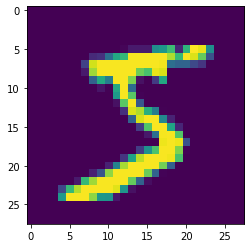

In [10]:
plt.imshow(X_train[0,:,:])

Since we only have 20 000 samples for the USPS dataset, we will keep only 20 000 samples from the MNIST dataset. 

In [11]:
mnist = X_train[np.random.choice(range(60000), 20000), :, :]

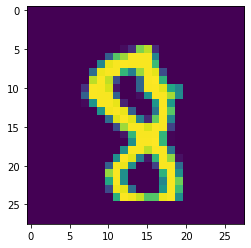

In [14]:
plt.imshow(mnist[0,:,:])

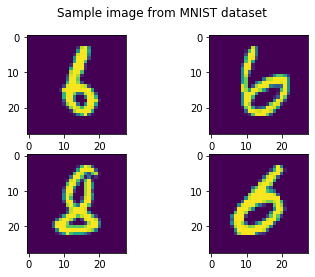

In [15]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mnist[15000,:,:])
axarr[0,1].imshow(mnist[450,:,:])
axarr[1,0].imshow(mnist[2000,:,:])
axarr[1,1].imshow(mnist[31,:,:])
f.suptitle('Sample image from MNIST dataset')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
usps = np.load("/content/gdrive/My Drive/Deep Learning ensae/usps_array.npy")

In [0]:
usps.shape 

(19999, 28, 28)

In [0]:
plt.gray() #just to display every following images in gray scale

<Figure size 432x288 with 0 Axes>

Sample from the USPS Dataset

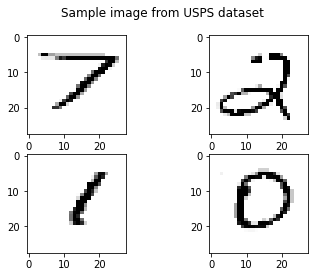

In [0]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(usps[15000,:,:])
axarr[0,1].imshow(usps[4500,:,:])
axarr[1,0].imshow(usps[2000,:,:])
axarr[1,1].imshow(usps[30,:,:])
f.suptitle('Sample image from USPS dataset')
plt.show()

Sample from the MNIST dataset

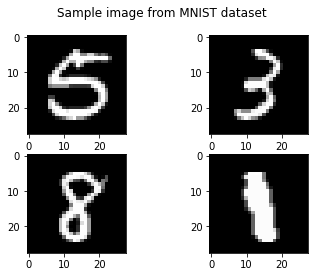

In [0]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mnist[15000,:,:])
axarr[0,1].imshow(mnist[450,:,:])
axarr[1,0].imshow(mnist[2000,:,:])
axarr[1,1].imshow(mnist[31,:,:])
f.suptitle('Sample image from MNIST dataset')
plt.show()

Looking at the picture we are going to use to perform image translation, one can see that this is in reality a simple task. This is why we will not use a very complex architecture for the generators and discriminators of the GANs, this will also allow for faster algorithm and less computationnal time. However, it would be quite straightforward to implement any kind of architecture by changing the Cycle_GAN object which is presented below. 

# Creation of the model

In this section we build the model by implementing the class Cycle_GAN. This class gather the structure of the generator and the discriminators. \\
For the generators, we use an alternation of convolution layers and non-linear layers (leaky relu). The surface of the filters is 3 X 3. The first convolution layer had 8 filtres, the second has 4 and the last one has 1 to get a 2D picture at the end. We also use biases at each layer. At the end of the neural networks we use a tanh activation with a linear transformation to fall back into the picture domain. \\
For the discriminators, we also use an alternation of linear (convolution layers) and non-linear layers (relu). Before the sigmoid, we flattened the output of the convolution network and apply a matrix product to get a single number.

In [0]:
class Cycle_GAN(object):

  def __init__(self, color=False, std=0.02):
    self.n_channel = 1
    if color:
      self.n_channel = 3
    # Generator G weights
    self.W1_genG = tf.Variable(std * np.random.randn(3,3,self.n_channel,8), shape=[3,3,self.n_channel,8], trainable=True, name="G_filter_1")
    self.b1_genG = tf.Variable(np.zeros((8)), shape=(8), trainable=True, name="G_bias_1")
    self.W2_genG = tf.Variable(std * np.random.randn(3,3,8,4), shape=[3,3,8,4])
    self.b2_genG = tf.Variable(np.zeros((4)), shape=(4))
    self.W3_genG = tf.Variable(std * np.random.randn(3,3,4,self.n_channel), shape=[3,3,4,self.n_channel])
    self.b3_genG = tf.Variable(np.zeros((self.n_channel)), shape=(self.n_channel))
    # Generator F weights
    self.W1_genF = tf.Variable(std * np.random.randn(3,3,self.n_channel,8), shape=[3,3,self.n_channel,8])
    self.b1_genF = tf.Variable(np.zeros((8)), shape=(8))
    self.W2_genF = tf.Variable(std * np.random.randn(3,3,8,4), shape=[3,3,8,4])
    self.b2_genF = tf.Variable(np.zeros((4)), shape=(4))
    self.W3_genF = tf.Variable(std * np.random.randn(3,3,4,self.n_channel), shape=[3,3,4,self.n_channel])
    self.b3_genF = tf.Variable(np.zeros((self.n_channel)), shape=(self.n_channel))
    # Discriminator DX weights
    self.W1_disDX = tf.Variable(std * np.random.randn(3,3,self.n_channel,8), shape=[3,3,self.n_channel,8])
    self.b1_disDX = tf.Variable(np.zeros((8)), shape=(8))
    self.W2_disDX = tf.Variable(std * np.random.randn(3,3,8,4), shape=[3,3,8,4])
    self.b2_disDX = tf.Variable(np.zeros((4)), shape=(4))
    self.W3_disDX = tf.Variable(std * np.random.randn(3,3,4,1), shape=[3,3,4,1])
    self.b3_disDX = tf.Variable(np.zeros((1)), shape=(1))
    self.W4_disDX = tf.Variable(std * np.random.randn(1, 784), shape=[1, 784])
    self.b4_disDX = tf.Variable(np.zeros((1)), shape=(1))
    # Discriminator DY weights
    self.W1_disDY = tf.Variable(std * np.random.randn(3,3,self.n_channel,8), shape=[3,3,self.n_channel,8])
    self.b1_disDY = tf.Variable(np.zeros((8)), shape=(8))
    self.W2_disDY = tf.Variable(std * np.random.randn(3,3,8,4), shape=[3,3,8,4])
    self.b2_disDY = tf.Variable(np.zeros((4)), shape=(4))
    self.W3_disDY = tf.Variable(std * np.random.randn(3,3,4,1), shape=[3,3,4,1])
    self.b3_disDY = tf.Variable(np.zeros((1)), shape=(1))
    self.W4_disDY = tf.Variable(std * np.random.randn(1, 784), shape=[1, 784])
    self.b4_disDY = tf.Variable(np.zeros((1)), shape=(1))

  def generator(self, mode, input_gen):  
    """ Both GANs will have the same architecture and therefore it is only described once.
        Generator block for the GAN of architecture : 

        - Convolution Layer, 8 filters (3, 3, n_channels), stride = 1, padding same
        - Add bias
        - Leaky Relu non linearity
        - Convolution Layer, 4 filters (3, 3, 8), stride = 1, padding same  
        - Add bias
        - Leaky Relu non linearity
        - Convolution Layer, n_channels filters (3, 3, 4), stride = 1, padding same 
        - Add bias
        - tanh non linearity
        - Linear transform to fall within image range

        ------------
        Params : 
        input_gen : tensor of shape (n, 28, 28, n_channels)
        mode : "XtoY" for the generator translating X to Y, "YtoX" for the generator translating Y to X
        ------------
        Returns :
        tensor of shape (n, 28, 28, n_channels)
    """ 
    n = input_gen.shape[0]
    if mode == "XtoY":
      G1 = tf.nn.conv2d(input_gen, self.W1_genG, strides=[1,1,1,1], padding='SAME')
      G1 = tf.nn.bias_add(G1, self.b1_genG)
      A1 = tf.nn.leaky_relu(G1)
      G2 = tf.nn.conv2d(A1, self.W2_genG, strides=[1,1,1,1], padding='SAME')
      G3 = tf.nn.bias_add(G2, self.b2_genG)
      A2 = tf.nn.leaky_relu(G3)
      G4 = tf.nn.conv2d(A2, self.W3_genG, strides=[1,1,1,1], padding='SAME')
      G5 = tf.nn.bias_add(G4, self.b3_genG)
      gen = 0.5*tf.nn.tanh(G5) + 0.5 #tanh activitation + simple linear transform to fall back within image domain

    elif mode =="YtoX":
      F1 = tf.nn.conv2d(input_gen, self.W1_genF, strides=[1,1,1,1], padding='SAME')
      F1 = tf.nn.bias_add(F1, self.b1_genF)
      A1 = tf.nn.leaky_relu(F1)
      F2 = tf.nn.conv2d(F1, self.W2_genF, strides=[1,1,1,1], padding='SAME')
      F3 = tf.nn.bias_add(F2, self.b2_genF)
      A2 = tf.nn.leaky_relu(F3)
      F4 = tf.nn.conv2d(A2, self.W3_genF, strides=[1,1,1,1], padding='SAME')
      F5 = tf.nn.bias_add(F4, self.b3_genF)
      gen = 0.5*tf.nn.tanh(F5) + 0.5 #tanh activitation + simple linear transform to fall back within image domain

    return gen

  def discriminator(self, mode, input_dis):
    """ Both GANs will have the same architecture and therefore it is only described once.
        Discriminator block for the GAN of architecture : 

        - Convolution Layer, 8 filters (3, 3, n_channels), stride = 1, padding = same
        - Add bias
        - Relu non linearity
        - Convolution Layer, 4 filters (3, 3, 8), stride = 1, padding = same
        - Add bias
        - Relu non linearity
        - Convolution Layer, 1 filters (3, 3, 4), stride = 1, padding = same  
        - Add bias
        - Relu non linearity
        - Reshaping 
        - L2 normalize
        - Fully Connected
        - Sigmoid non linearity

        ------------
        Params : 
        input_dis : tensor of shape (n, 28, 28, n_channels)
        mode : "DX" for the X discriminator, "DY" for the Y discriminator
        ------------
        Returns :
        tensor of shape (n, 1)
    """
    if mode == "DX":
      DX1 = tf.nn.conv2d(input_dis, self.W1_disDX, strides=[1,1,1,1], padding='SAME')
      DX1 = tf.nn.bias_add(DX1, self.b1_disDX)
      A1 = tf.nn.relu(DX1)
      DX2 = tf.nn.conv2d(A1, self.W2_disDX, strides=[1,1,1,1], padding='SAME')
      DX3 = tf.nn.bias_add(DX2, self.b2_disDX)
      A2 = tf.nn.relu(DX3)
      DX4 = tf.nn.conv2d(A2, self.W3_disDX, strides=[1,1,1,1], padding='SAME')
      DX5 = tf.nn.bias_add(DX4, self.b3_disDX)
      A3 = tf.nn.relu(DX5)
      sh = A3.get_shape().as_list()
      A4 = tf.reshape(A3, shape=(sh[0], np.product(sh[1:]))) #flattening
      A5 = tf.math.l2_normalize(A4)
      DX6 = tf.linalg.matvec(self.W4_disDX, A5) + self.b4_disDX
      dis = tf.nn.sigmoid(DX6)
      
    elif mode == "DY":
      DY1 = tf.nn.conv2d(input_dis, self.W1_disDY, strides=[1,1,1,1], padding='SAME')
      DY1 = tf.nn.bias_add(DY1, self.b1_disDY)
      A1 = tf.nn.relu(DY1)
      DY2 = tf.nn.conv2d(A1, self.W2_disDY, strides=[1,1,1,1], padding='SAME')
      DY3 = tf.nn.bias_add(DY2, self.b2_disDY)
      A2 = tf.nn.relu(DY3)
      DY4 = tf.nn.conv2d(A2, self.W3_disDY, strides=[1,1,1,1], padding='SAME')
      DY5 = tf.nn.bias_add(DY4, self.b3_disDY)
      A3 = tf.nn.relu(DY5)
      sh = A3.get_shape().as_list()
      A4 = tf.reshape(A3, shape=(sh[0], np.product(sh[1:]))) #flattening
      A5 = tf.math.l2_normalize(A4)
      DY6 = tf.linalg.matvec(self.W4_disDY, A5) + self.b4_disDY
      dis = tf.nn.sigmoid(DY6)
      
    return dis




# Optimization process

After defining the model, we use our data to optimize the weights of the neural network during the training process. To do that, each component of the cycle gan will have a loss function to minimize.  By using the same previous notations we define the loss function for each generator and discriminator:
$$L_{G} = \mathbb{E}_{x∼p_{data}(x)}[(DY(G(x))-1)^2] + \lambda L_{cycle}$$ \\
$$L_{F} = \mathbb{E}_{y∼p_{data}(y)}[(DX(F(y))-1)^2] + \lambda L_{cycle}$$ \\

Where $L_{cycle} = \mathbb{E}_{x∼p_{data}(x)}[\parallel F(G(x)) - x \parallel_1] + \mathbb{E}_{y∼p_{data}(y)}[\parallel G(F(y)) - y \parallel_1]$ \\
\\
$$L_{DX} = \mathbb{E}_{x∼p_{data}(x)}[(DX(x) - 1)^2] + \mathbb{E}_{y∼p_{data}(y)}[DX(F(y))^2]$$ \\
$$L_{DY} = \mathbb{E}_{y∼p_{data}(y)}[(DY(y) - 1)^2] + \mathbb{E}_{x∼p_{data}(x)}[DY(G(x))^2]$$

In [0]:
def sample(data, n):
  return data[np.random.choice(range(len(data)), n), :, :, np.newaxis]

We now write a function that will perfom cycle GAN training.

In [0]:
def train_cyclegan(model, X_data, Y_data, opt, n_iter, plot_every, batch_size, lbda):
  """Trains a GAN object containing two generators and two critics using the cycle gan procedure. 
     Learns image to image translation between X_data and Y_data
     -------------
     Params : 
        model : Cycle_GAN object
        X_data : array of shape (n_sample, height, width, channels)
        Y_data : array of shape (n_sample, height, width, channels)
        opt : tensorflow optimizer like object 
        n_iter : int, number of iteration
        plot_every : int, plot of sample translation every plot_every iterations
        batch_size : int
        lbda : float positive, controls the importance of the cycle loss
     -------------
     Returns :
      None
      ------------
      model object is modified in place
  """
  for t in range(n_iter):
    #sampling data
    x = sample(X_data, batch_size)
    y = sample(Y_data, batch_size)
    with tf.device('/device:GPU:0'): 
        with tf.GradientTape(persistent=True) as tape:
          genY = model.generator("XtoY", x)
          genX = model.generator("YtoX", y)
          disX_target = model.discriminator("DX", x) #critic on real X
          disY_target = model.discriminator("DY", y) #critic on real Y
          disX_gen = model.discriminator("DX", genX) #critic on fake X
          disY_gen = model.discriminator("DY", genY) #critic on fake Y
          f_cycle = model.generator("YtoX", genY) #forward cycle
          b_cycle = model.generator("XtoY", genX) #backward cycle
          #------------------------------------------------------
          # Computing losses for the cycle gan loss - note that we are using the trick of the least square losses instead of the negative log likelihood
          #------------------------------------------------------
          loss_cycle = lbda * tf.reduce_mean(tf.math.add(tf.norm(tf.math.subtract(f_cycle, x),ord=1, axis=[-3,-2]), tf.norm(tf.math.subtract(b_cycle, y), ord=1, axis=[-3,-2])), axis=0)
          
          loss_cycle = lbda * tf.reduce_mean(tf.math.add(tf.norm(tf.math.subtract(output_gen_1_gen_2, sample_1),ord=1, axis=[-3,-2]), tf.norm(tf.math.subtract(output_gen_2_gen_1, sample_2), ord=1, axis=[-3,-2])), axis=0)
        loss_cycle= tf.reduce_mean(tf.abs(output_gen_1_gen_2-sample_1)) + tf.reduce_mean(tf.abs(output_gen_2_gen_1-sample_2))
            
        # Generator losses
          loss_genXtoY = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(disY_gen, 1)), loss_cycle), axis=0)
          loss_genYtoX = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(disX_gen, 1)), loss_cycle), axis=0)

          # Discriminator losses
          loss_disDX = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(disX_target, 1)), tf.math.square(disX_gen)), axis=0)
          loss_disDY = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(disY_target, 1)), tf.math.square(disY_gen)), axis=0)
            

        #variable for each block to optimize
        var_genX = [model.W1_genF, model.b1_genF, model.W2_genF, model.b2_genF, model.W3_genF, model.b3_genF]
        var_genY = [model.W1_genG, model.b1_genG, model.W2_genG, model.b2_genG, model.W3_genG, model.b3_genG]
        var_disX = [model.W1_disDX, model.b1_disDX, model.W2_disDX, model.b2_disDX, model.W3_disDX, model.b3_disDX, model.W4_disDX, model.b4_disDX]
        var_disY = [model.W1_disDY, model.b1_disDY, model.W2_disDY, model.b2_disDY, model.W3_disDY, model.b3_disDY, model.W4_disDY, model.b4_disDY]

        #computing grandients
        gradients_genXtoY = tape.gradient(loss_genXtoY, var_genY)
        gradients_genYtoX = tape.gradient(loss_genYtoX, var_genX)
        gradients_disX = tape.gradient(loss_disDX, var_disX)
        gradients_disY = tape.gradient(loss_disDY, var_disY)


        #applying gradients
        opt.apply_gradients(zip(gradients_genXtoY, var_genY))
        opt.apply_gradients(zip(gradients_genYtoX, var_genX))
        opt.apply_gradients(zip(gradients_disX, var_disX))
        opt.apply_gradients(zip(gradients_disY, var_disY))

    if (t+1)%plot_every == 500:
      print("Iteration", t)
      print("_____________________")
      print("Sample created image from mnist to usps : ")
      xp = sample(X_data, 1)
      genY_sample = model.generator("XtoY", xp)
      xu = sample(Y_data, 1)
      genX_sample = model.generator("YtoX", xu)
      f, axarr = plt.subplots(1,2)
      axarr[0].imshow(xp[0,:,:,0])
      axarr[1].imshow(genY_sample[0,:,:,0])
      axarr[0].set_title("MNIST sample")
      axarr[1].set_title("Transalated towards USPS")
      plt.show()
      f2, axarr2 = plt.subplots(1,2)
      axarr2[0].imshow(xu[0,:,:,0])
      axarr2[1].imshow(genX_sample[0,:,:,0])
      axarr2[0].set_title("USPS sample")
      axarr2[1].set_title("Transalated towards MNIST")
      plt.show()
      print("=====================")
      print("=====================")

  
  return None

In [0]:
cgan = Cycle_GAN(std=1)
n_samples = 20000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
n_iter = 15000
batch_size = 200
epochs = (n_iter * batch_size )/(n_samples)
lbda = 10 #the factor lambda for which multiplies the cycle loss, we choose 10 as is done in the paper
plot_every = 500 #plot sample of generated image every plot_every iteration
#with n_iter = 10000 and batch_size of 200, we will go over 150 epochs

Each 500 iterations we sample images and their translation and display the results to that we can monitor and visualize the training and its evolution.

Iteration 499
_____________________
Sample created image from mnist to usps : 


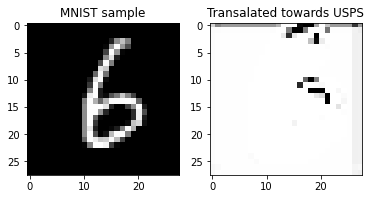

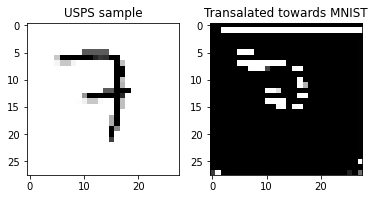

Iteration 999
_____________________
Sample created image from mnist to usps : 


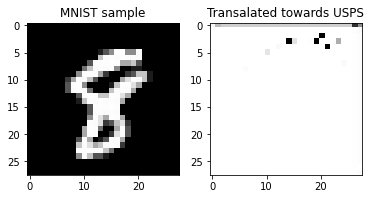

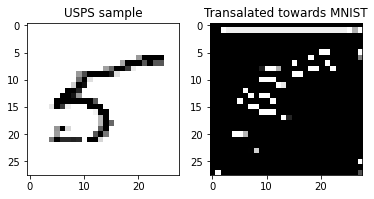

Iteration 1499
_____________________
Sample created image from mnist to usps : 


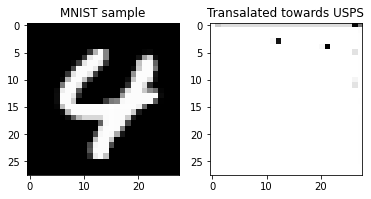

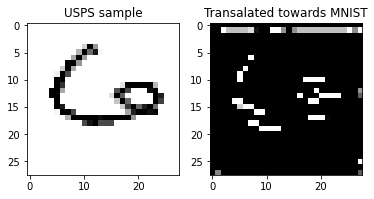

Iteration 1999
_____________________
Sample created image from mnist to usps : 


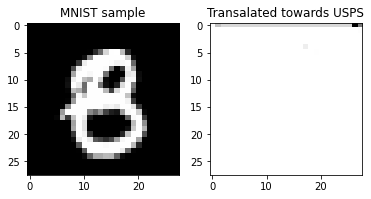

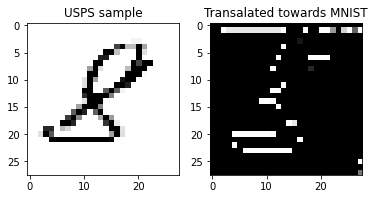

Iteration 2499
_____________________
Sample created image from mnist to usps : 


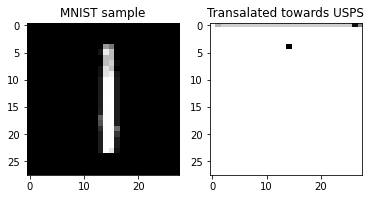

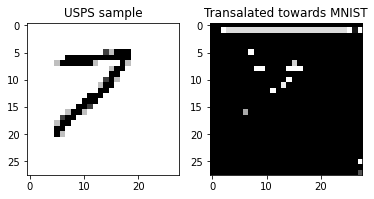

Iteration 2999
_____________________
Sample created image from mnist to usps : 


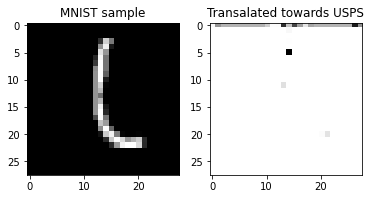

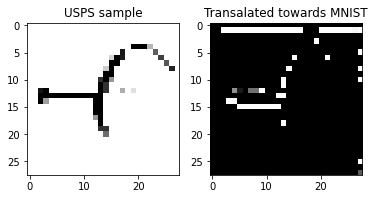

Iteration 3499
_____________________
Sample created image from mnist to usps : 


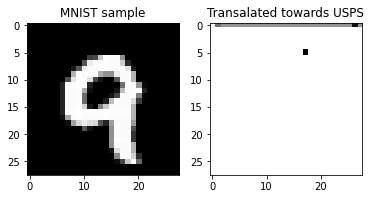

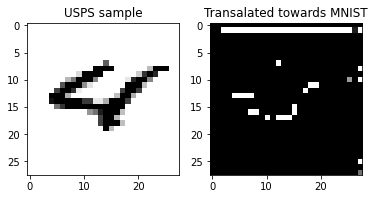

Iteration 3999
_____________________
Sample created image from mnist to usps : 


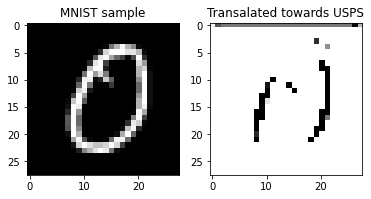

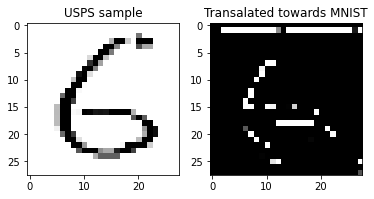

Iteration 4499
_____________________
Sample created image from mnist to usps : 


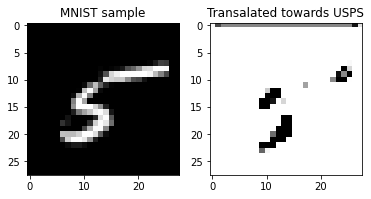

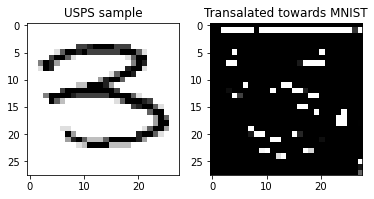

Iteration 4999
_____________________
Sample created image from mnist to usps : 


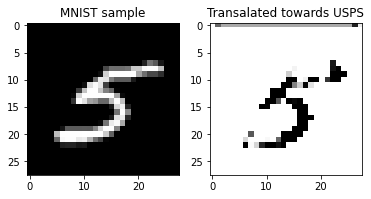

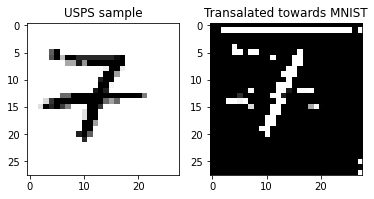

Iteration 5499
_____________________
Sample created image from mnist to usps : 


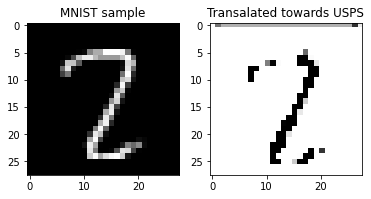

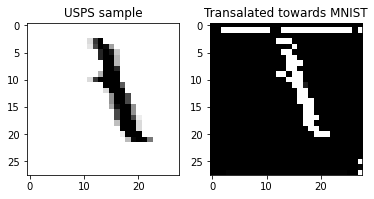

Iteration 5999
_____________________
Sample created image from mnist to usps : 


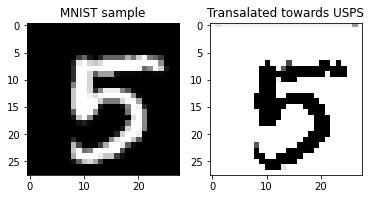

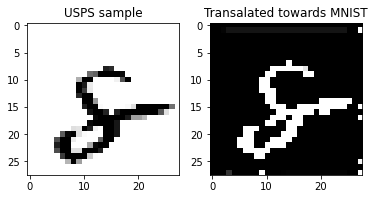

Iteration 6499
_____________________
Sample created image from mnist to usps : 


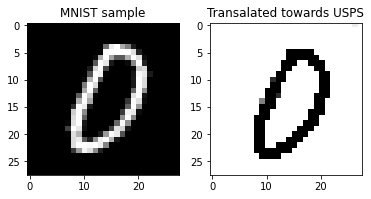

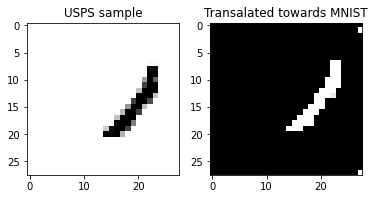

Iteration 6999
_____________________
Sample created image from mnist to usps : 


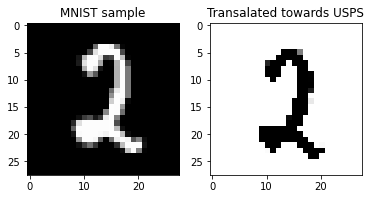

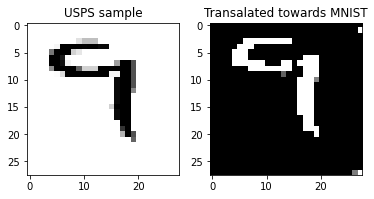

Iteration 7499
_____________________
Sample created image from mnist to usps : 


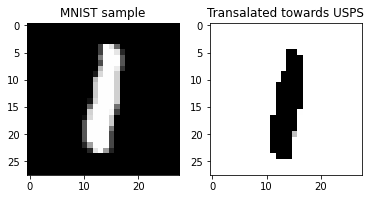

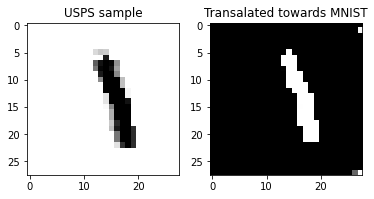

Iteration 7999
_____________________
Sample created image from mnist to usps : 


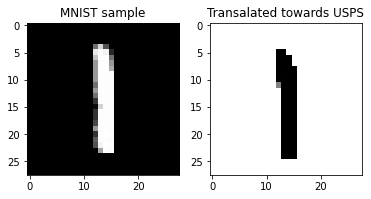

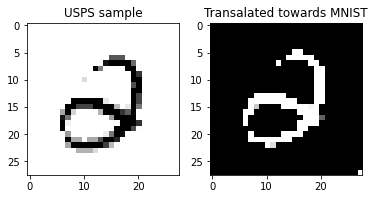

Iteration 8499
_____________________
Sample created image from mnist to usps : 


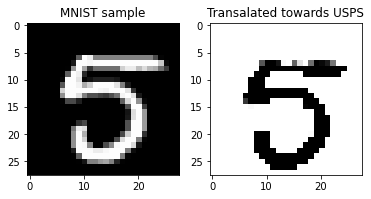

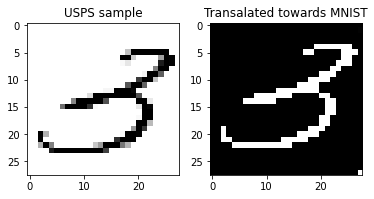

Iteration 8999
_____________________
Sample created image from mnist to usps : 


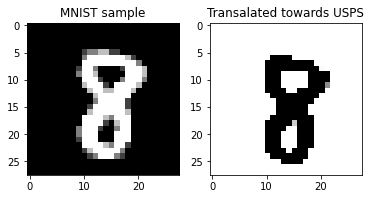

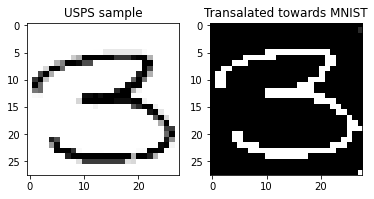

Iteration 9499
_____________________
Sample created image from mnist to usps : 


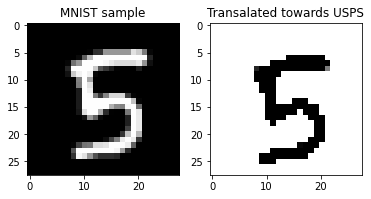

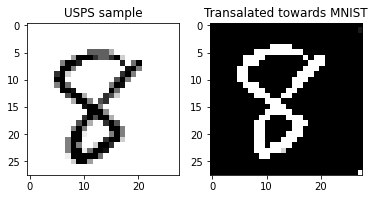

Iteration 9999
_____________________
Sample created image from mnist to usps : 


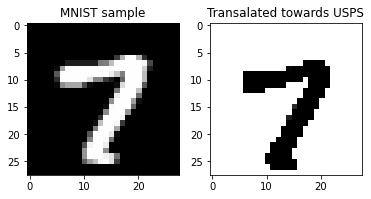

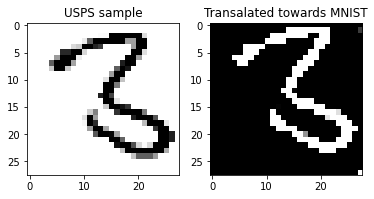

Iteration 10499
_____________________
Sample created image from mnist to usps : 


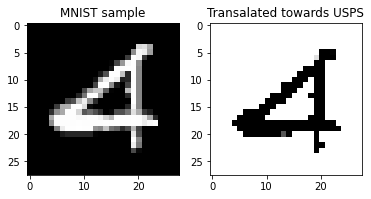

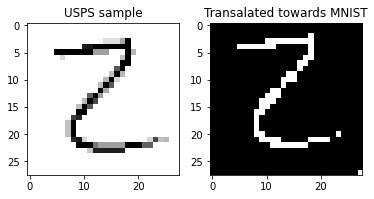

Iteration 10999
_____________________
Sample created image from mnist to usps : 


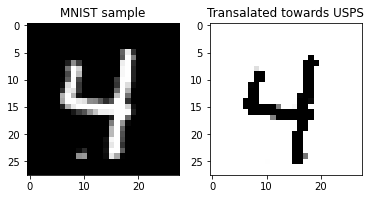

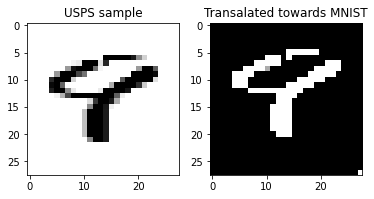

Iteration 11499
_____________________
Sample created image from mnist to usps : 


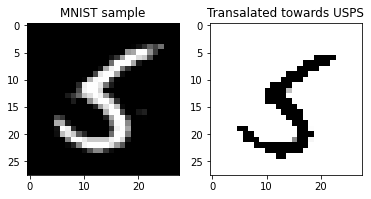

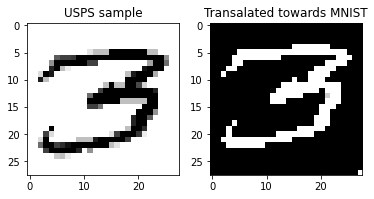

Iteration 11999
_____________________
Sample created image from mnist to usps : 


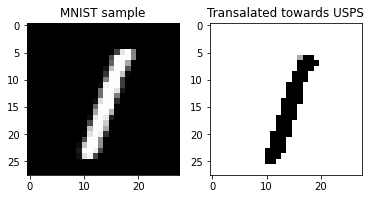

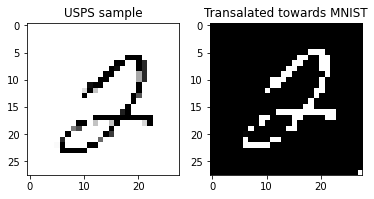

Iteration 12499
_____________________
Sample created image from mnist to usps : 


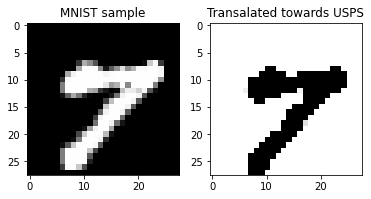

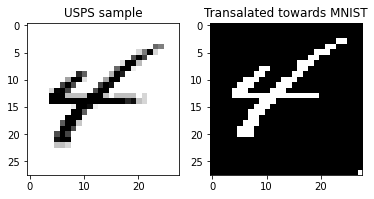

Iteration 12999
_____________________
Sample created image from mnist to usps : 


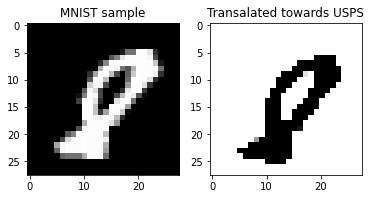

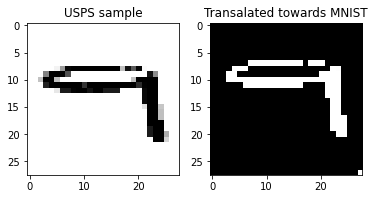

Iteration 13499
_____________________
Sample created image from mnist to usps : 


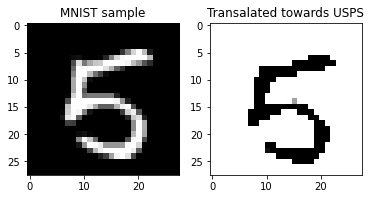

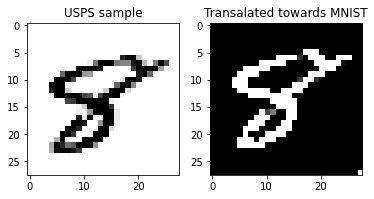

Iteration 13999
_____________________
Sample created image from mnist to usps : 


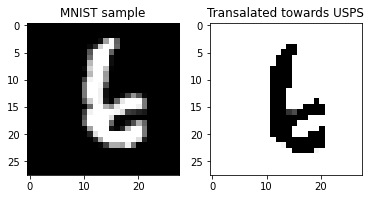

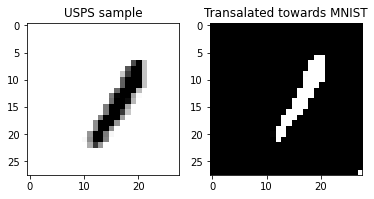

Iteration 14499
_____________________
Sample created image from mnist to usps : 


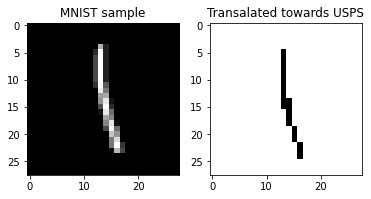

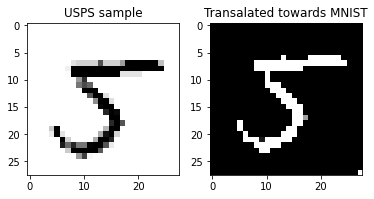

Iteration 14999
_____________________
Sample created image from mnist to usps : 


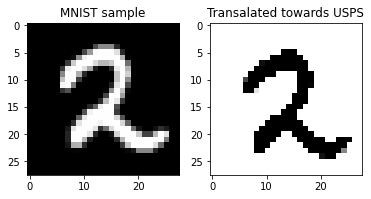

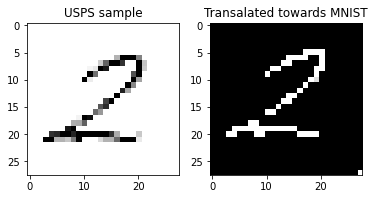

In [0]:
train_cyclegan(cgan, mnist, usps, optimizer, n_iter, plot_every, batch_size, lbda)

# Results 


After having trained the model for 150 epochs, the generators are able to translate the digits as below:


We will test the translation on the a sample of the training data. Then to evaluate it on unseen data, we drew ourselves some numbers that match the mnist and usps data format to evaluate the translation on new data.

In [0]:
#This is the data we drew ourselves
usps_test = np.load("/content/gdrive/My Drive/Deep Learning ensae/uspstest.npy")
mnist_test = np.load("/content/gdrive/My Drive/Deep Learning ensae/mnisttest.npy")

### First vizualize the results on the training set


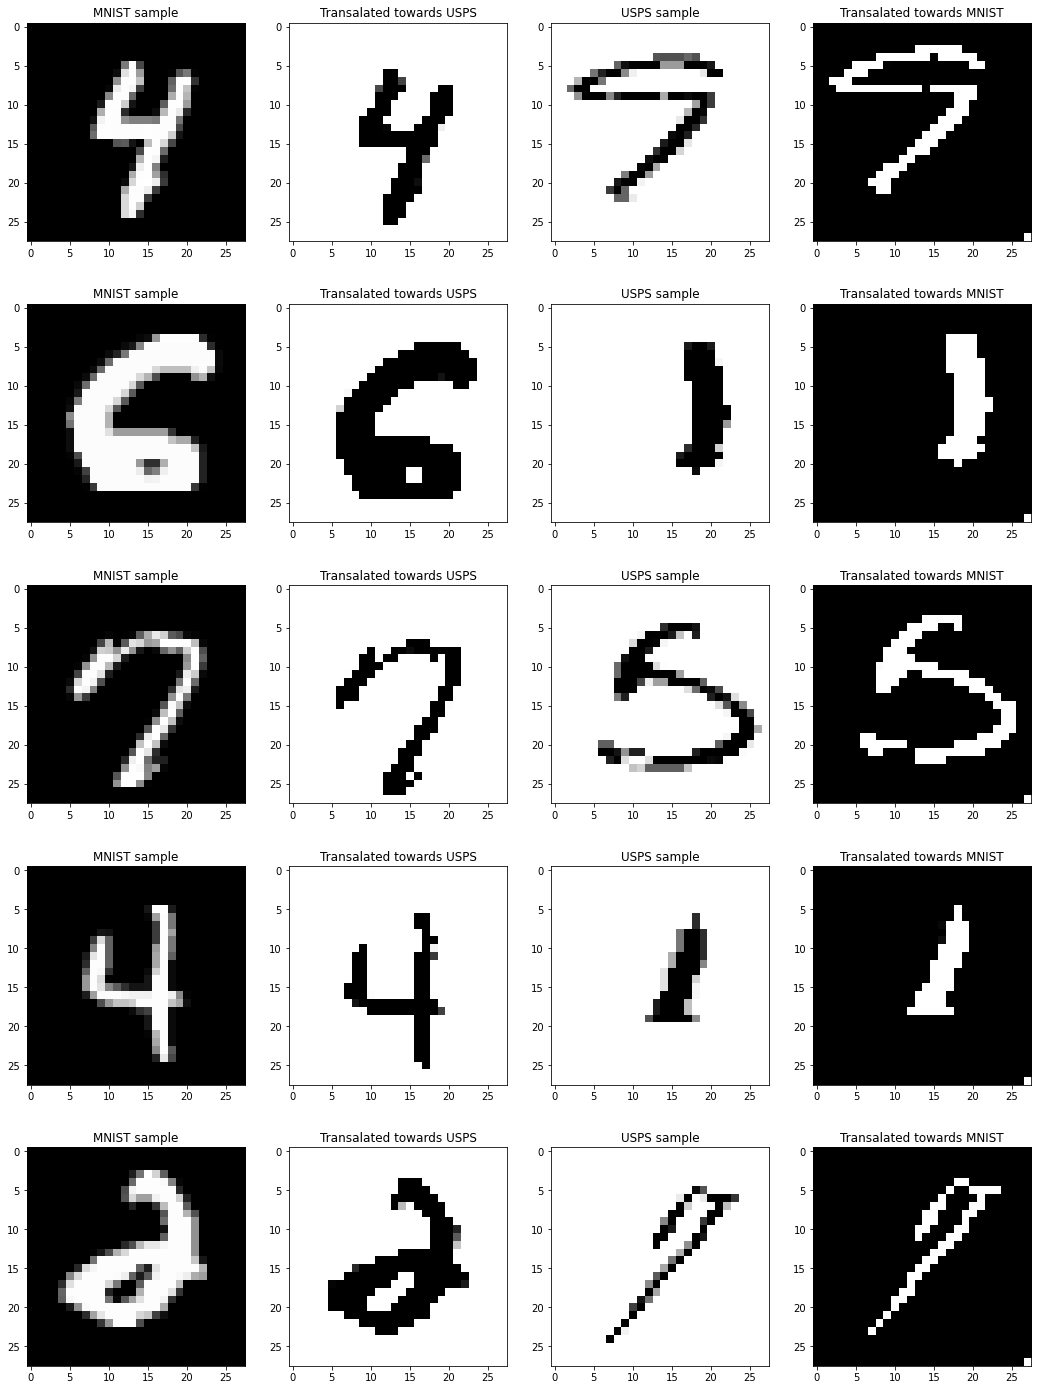

In [35]:
xp = sample(mnist, 5)
genY_sample = cgan.generator("XtoY", xp)
xu = sample(usps, 5)
genX_sample = cgan.generator("YtoX", xu)
f, axarr = plt.subplots(5,4, figsize=(18,25))

for i in range(5):
  axarr[i,0].imshow(xp[i,:,:,0])
  axarr[i,1].imshow(genY_sample[i,:,:,0])
  axarr[i,0].set_title("MNIST sample")
  axarr[i,1].set_title("Transalated towards USPS")

for j in range(5):
  axarr[j,2].imshow(xu[j,:,:,0])
  axarr[j,3].imshow(genX_sample[j,:,:,0])
  axarr[j,2].set_title("USPS sample")
  axarr[j,3].set_title("Transalated towards MNIST")

plt.show()

#### Now, on our own data

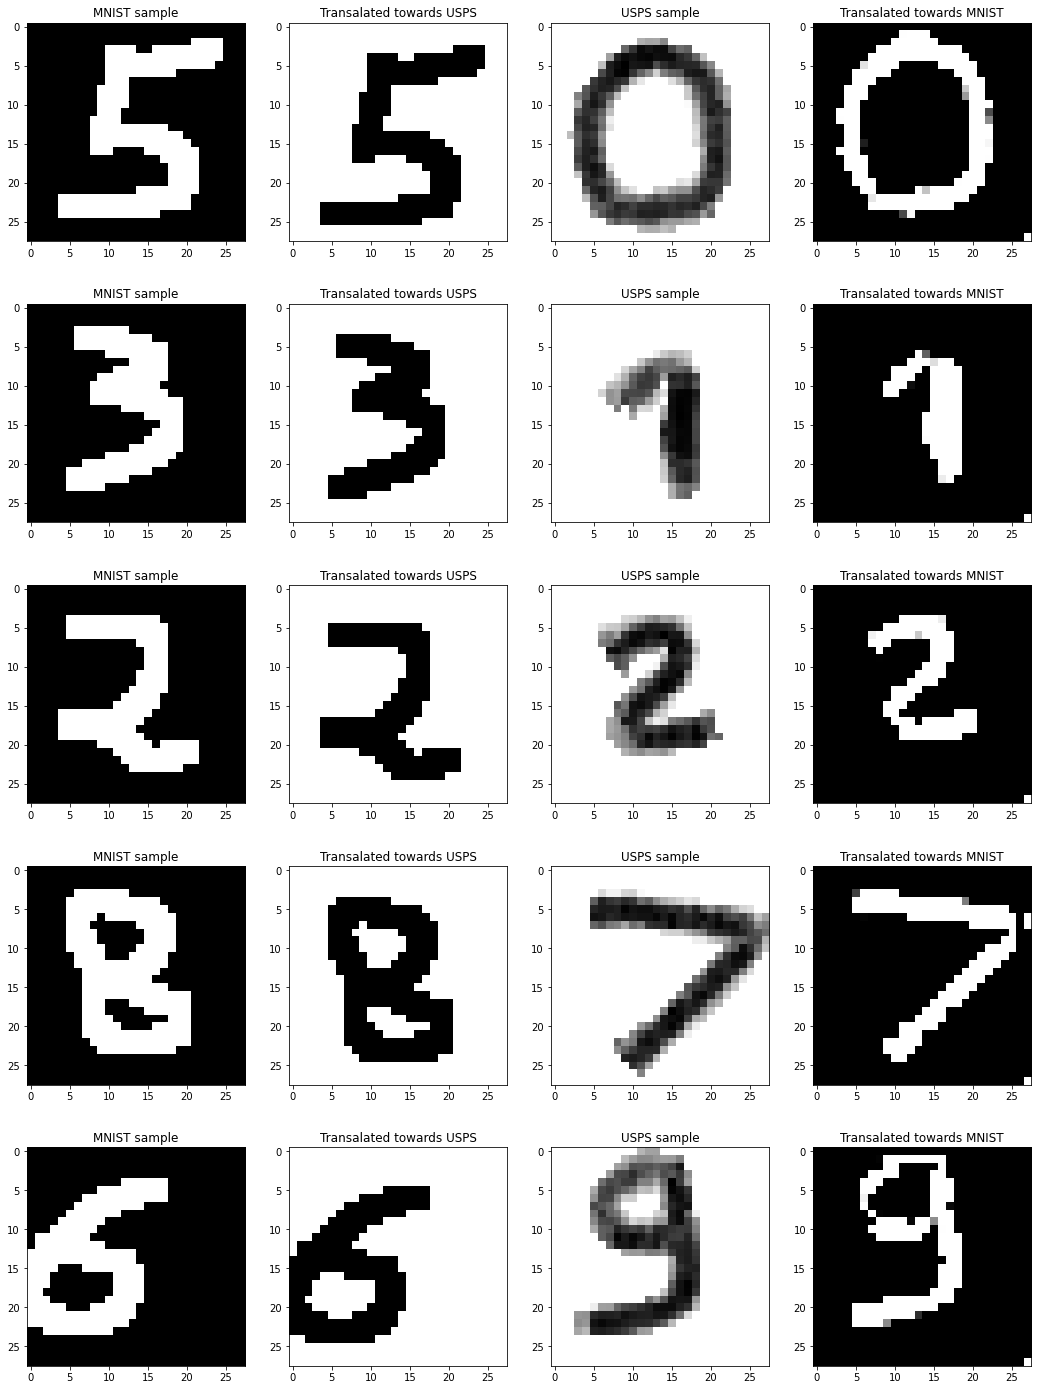

In [38]:
xp = mnist_test[:,:,:,np.newaxis]
genY_sample = cgan.generator("XtoY", xp)
xu = usps_test[:,:,:,np.newaxis]
genX_sample = cgan.generator("YtoX", xu)
f, axarr = plt.subplots(5,4, figsize=(18,25))

for i in range(5):
  axarr[i,0].imshow(xp[i,:,:,0])
  axarr[i,1].imshow(genY_sample[i,:,:,0])
  axarr[i,0].set_title("MNIST sample")
  axarr[i,1].set_title("Transalated towards USPS")

for j in range(5):
  axarr[j,2].imshow(xu[j,:,:,0])
  axarr[j,3].imshow(genX_sample[j,:,:,0])
  axarr[j,2].set_title("USPS sample")
  axarr[j,3].set_title("Transalated towards MNIST")

plt.show()

#### Random shape of data

We drew random shapes of data to see if the model is still able to translate images in the same way without having trained on it. 

In [0]:
#This is the data we drew ourselves
u_rand= np.load("/content/gdrive/My Drive/Deep Learning ensae/u_rand.npy")
m_rand = np.load("/content/gdrive/My Drive/Deep Learning ensae/m_rand.npy")

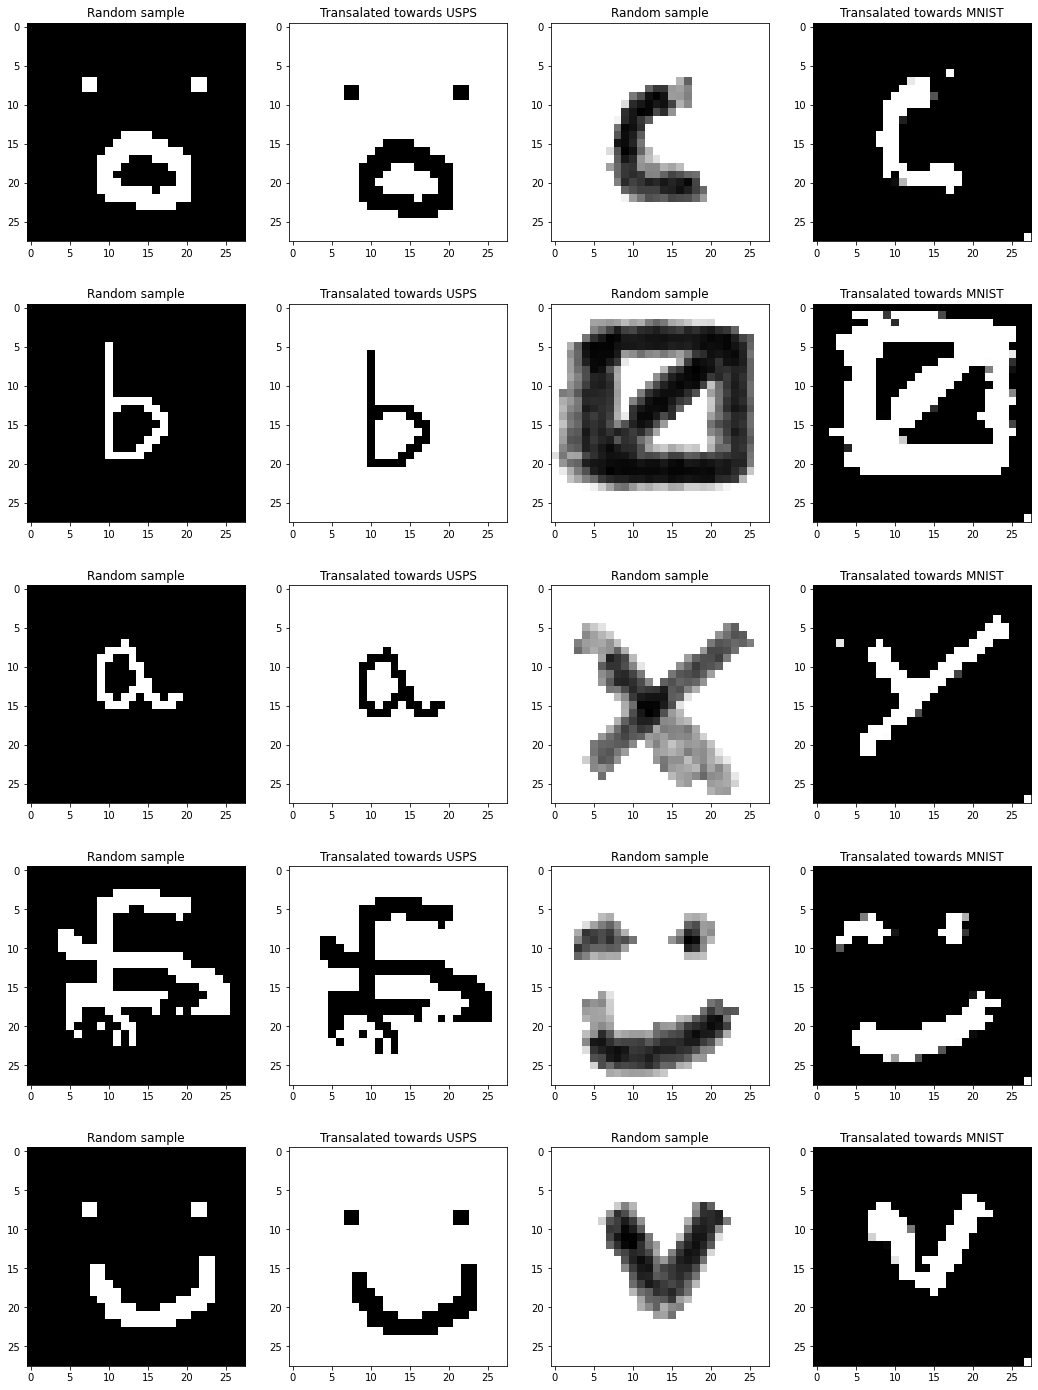

In [58]:
xp = m_rand[:,:,:,np.newaxis]
genY_sample = cgan.generator("XtoY", xp)
xu = u_rand[:,:,:,np.newaxis]
genX_sample = cgan.generator("YtoX", xu)
f, axarr = plt.subplots(5,4, figsize=(18,25))

for i in range(5):
  axarr[i,0].imshow(xp[i,:,:,0])
  axarr[i,1].imshow(genY_sample[i,:,:,0])
  axarr[i,0].set_title("Random sample")
  axarr[i,1].set_title("Transalated towards USPS")

for j in range(5):
  axarr[j,2].imshow(xu[j,:,:,0])
  axarr[j,3].imshow(genX_sample[j,:,:,0])
  axarr[j,2].set_title("Random sample")
  axarr[j,3].set_title("Transalated towards MNIST")

plt.show()

### We tried it on random sample of faces

We used the Faces in the Wild dataset and resized the images to be of size (28,28). We can see that, the translator roughly draw a sketch of a face, but the quality is quite poor as it could be expected. However, it is nice to observe these results, for some faces the sketch is quite good.


In [0]:
male = np.load("/content/gdrive/My Drive/Deep Learning ensae/malefaces.npy")
female = np.load("/content/gdrive/My Drive/Deep Learning ensae/femalefaces.npy")

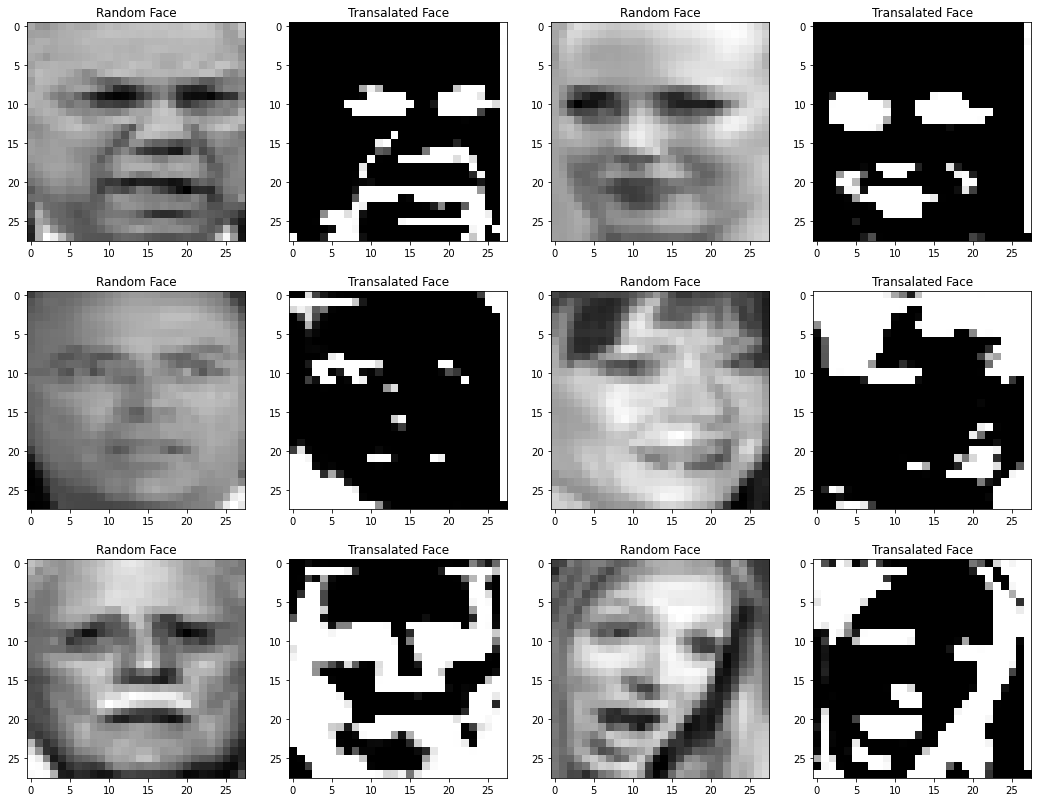

In [87]:
xp = male[np.random.choice(range(len(male)), 3),:,:,np.newaxis]
genY_sample = cgan.generator("XtoY", xp)
f, axarr = plt.subplots(3,4, figsize=(18,14))
xu = female[np.random.choice(range(len(female)), 3),:,:,np.newaxis]
genX_sample = cgan.generator("XtoY", xu)

for i in range(3):
  axarr[i,0].imshow(xp[i,:,:,0])
  axarr[i,1].imshow(genY_sample[i,:,:,0])
  axarr[i,0].set_title("Random Face")
  axarr[i,1].set_title("Transalated Face")

for j in range(3):
  axarr[j,2].imshow(xu[j,:,:,0])
  axarr[j,3].imshow(genX_sample[j,:,:,0])
  axarr[j,2].set_title("Random Face")
  axarr[j,3].set_title("Transalated Face")